In [113]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle

# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, mean_majority, sd_majority, cov_maj):
    
    """Helper function for creating classification problem with gaussians"""
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    #mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = ''):
    
    fig, ax = plt.subplots(1,1, figsize = (10,8))
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = ['Normal Wine','Bad Wine'], title = 'Confusion Matrix', cmap = plt.cm.Blues):
    
    " Helper function for plotting a confusion matrix"
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Helper function for correcting the intercept in models fitted on re-sampled data
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept

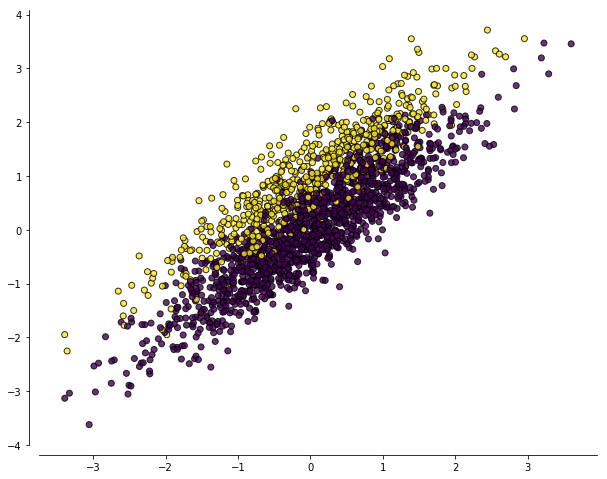

In [152]:
## Making the data ##

# Base rate and sample size
base_rate = 0.3
n = 2000

# Properties of the minority class distribution
mean_minority =  np.array([0,1])
sd_minority = np.array([1,1])
cov_minority = 0.9

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0.9

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority)

# Plot
plot_2d(x,y)                         

In [153]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, stratify = y)

Baseline accuracy score: 0.868


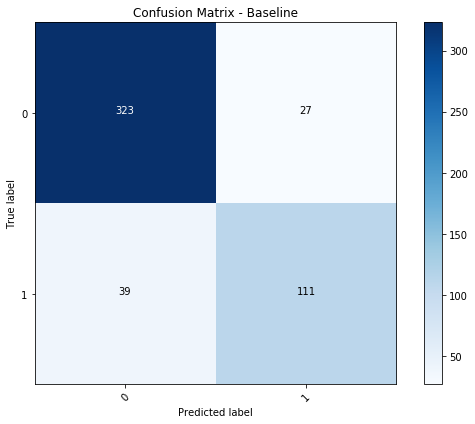

In [154]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1e4,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]

# Accuracy
accuracy_baseline = metrics.accuracy_score(y_test,baseline_pred)

print('Baseline accuracy score: ' + str(round(accuracy_baseline,4)))

# Set plot size
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix using sklearn metrix
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'])

[(-5, 5), Text(0,0.5,'$X_2$'), (-5, 5), Text(0.5,0,'$X_1$'), None]

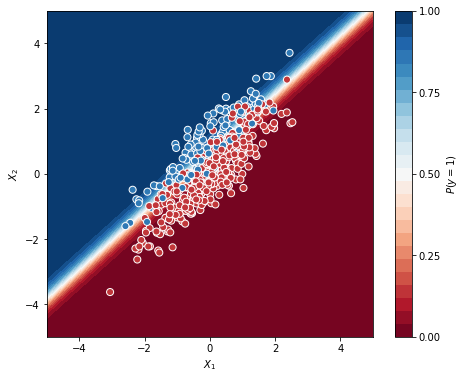

In [155]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = baseline_model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

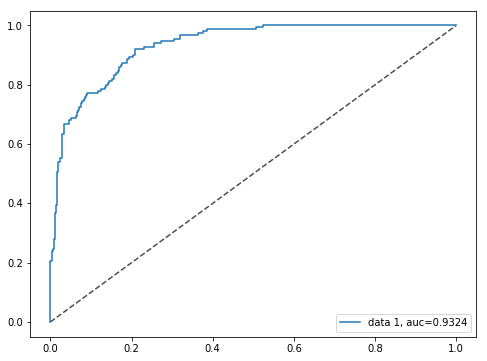

In [157]:
y_pred_proba = baseline_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

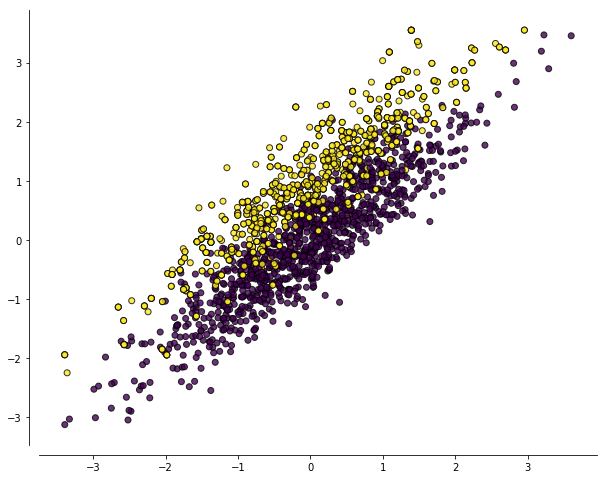

In [158]:
from imblearn import over_sampling 
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
oversampled_model.fit(X_oversampled, y_oversampled );

plot_2d(X_oversampled,y_oversampled)

##### NOW RE-WEIGHT THE LEARNED PROBABILITES!!! EXTREMLY IMPORTANT TO CHECK HERE #####

In [159]:
correct_intercept_logit(oversampled_model, y_train, y_oversampled)

# Make predictions on testing values
y_pred_oversampled = oversampled_model.predict(X_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_oversampled)
print(accuracy)

metrics.confusion_matrix(y_test,y_pred_oversampled)

0.868


array([[323,  27],
       [ 39, 111]])

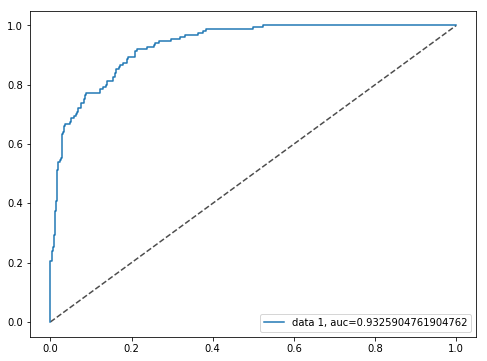

In [160]:
y_over_proba = oversampled_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_over_proba)
auc = metrics.roc_auc_score(y_test, y_over_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

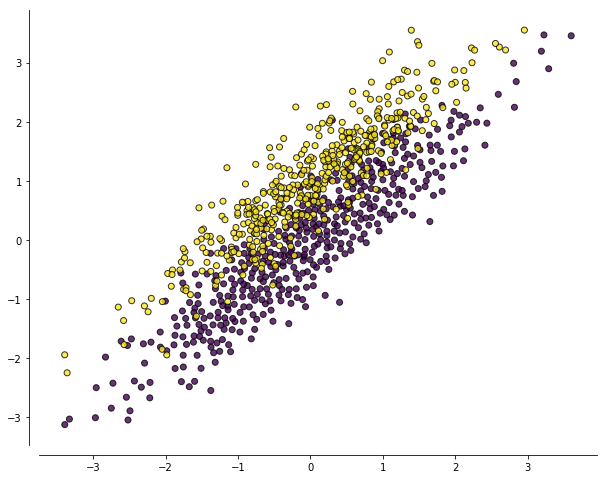

In [161]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_undersampled, y_undersampled = cc.fit_resample(X_train, y_train)

plot_2d(X_undersampled, y_undersampled)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
#undersampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
#undersampled_model.fit(X_undersampled, y_undersampled);


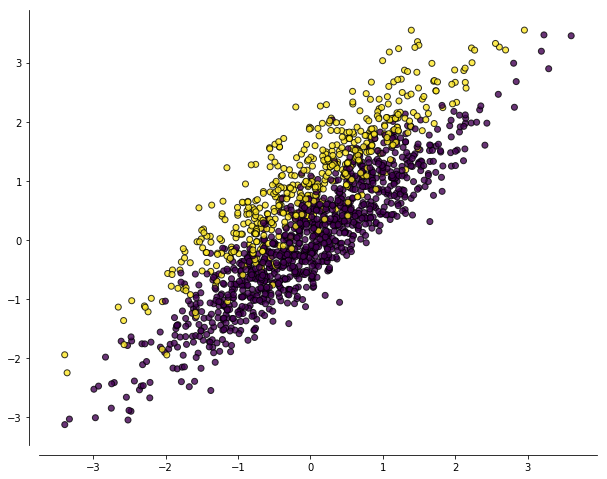

In [163]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors= 5, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(X_train,y_train)

plot_2d(x_smote,y_smote)

In [164]:
smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

# Make correction
correct_intercept_logit(smote_model, y_train, y_smote)

y_smote_proba = smote_model.predict_proba(X_test)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote)

0.484


array([[ 92, 258],
       [  0, 150]])

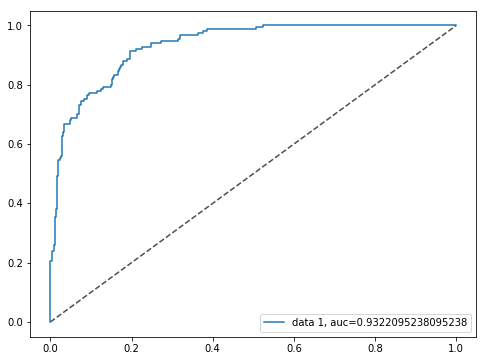

In [165]:
y_smote_proba = smote_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_smote_proba)
auc = metrics.roc_auc_score(y_test, y_smote_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[(-5, 5), Text(0,0.5,'$X_2$'), (-5, 5), Text(0.5,0,'$X_1$'), None]

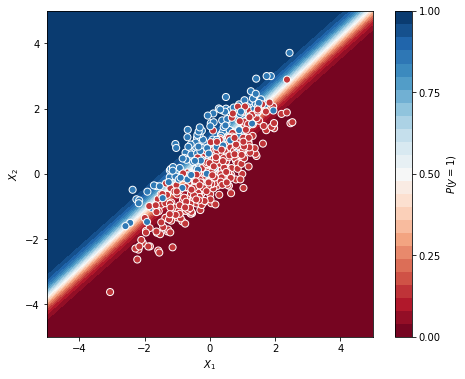

In [166]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = smote_model.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

In [167]:
n

2000

In [169]:
from sklearn.datasets import make_classification

In [202]:
## Try in higher dimensional problem , using make classificatio
n =1000
base_rate = 0.01
x, y = make_classification(n_samples = n,n_features = 10, n_informative =7, n_redundant = 0, n_repeated =0,
                          n_classes = 2, n_clusters_per_class = 1, weights =  [1-base_rate,base_rate],
                          class_sep = 0.6)
sum(y)

19

In [203]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, stratify = y)

Baseline accuracy score: 0.984


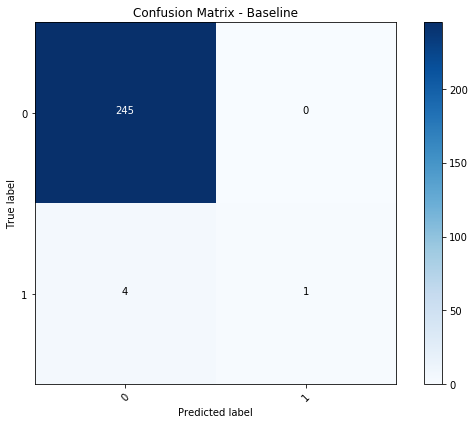

In [204]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1e4,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]

# Accuracy
accuracy_baseline = metrics.accuracy_score(y_test,baseline_pred)

print('Baseline accuracy score: ' + str(round(accuracy_baseline,4)))

# Set plot size
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix using sklearn metrix
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'])

In [205]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors= 5, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(X_train,y_train)

smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

# Make correction
correct_intercept_logit(smote_model, y_train, y_smote)

y_smote_proba = smote_model.predict_proba(X_test)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote)

0.668


array([[166,  79],
       [  4,   1]])